<a href="https://colab.research.google.com/github/aju22/Seq2Seq-Math-Addition/blob/main/Seq2Seq_for_Math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use GPU

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Data Generation

In [54]:
import numpy as np

In [55]:
N_ADDED = 2
LARGEST= 100
TRAIN_SAMPLES = 10000
TEST_SAMPLES = 100

In [56]:
def random_sum_data(samples, n_added, largest):
  X = []
  y = []
  for i in range(samples):
    num_seq = [np.random.randint(1, largest) for j in range(n_added)]
    sum_of_seq = [sum(num_seq)]

    X.append(num_seq)
    y.append(sum_of_seq)

  return X, y  

# Convert Data to String and Padding

In [57]:
max_input_seq_length = N_ADDED * np.ceil(np.log10(LARGEST+1)) + N_ADDED - 1
max_output_seq_length = np.ceil(np.log10(N_ADDED * (LARGEST+1)))

print("Max input length : {}".format(max_input_seq_length))
print("Max output length : {}".format(max_output_seq_length))

Max input length : 7.0
Max output length : 3.0


In [58]:
def data_to_string(X, y):
  X_str = []
  y_str = []
  
  for i in range(len(X)):
    
    data = X[i]
    data_str = "+".join([str(x) for x in data])
    
    if len(data_str) < max_input_seq_length:
      diff = max_input_seq_length - len(data_str)
      data_str += int(diff)*" "
    
    X_str.append(data_str)
    
    result_str = str(y[i][0])

    if len(result_str) < max_output_seq_length:
      diff = max_output_seq_length - len(result_str)
      result_str += int(diff)*" "

    y_str.append(result_str)

  return X_str, y_str

# Encode Strings

In [59]:
char2int = {'0' : 0, '1' : 1, '2' : 2, '3' : 3, '4' : 4, '5' : 5, '6' : 6, '7' : 7, '8' : 8, '9' : 9, '+' : 10, " " : 11}

In [60]:
int2char = {v : k for k, v in char2int.items()}

In [61]:
def encode(X_str, y_str):
  X_encoded = []
  y_encoded = []
  for i in range(len(X_str)):
    data_str = X_str[i]
    data_encoded = [char2int[char] for char in data_str]
    X_encoded.append(data_encoded)

    result_str = y_str[i]
    result_encoded = [char2int[char] for char in result_str]
    y_encoded.append(result_encoded)
    
  return X_encoded, y_encoded

# One-Hot-Encoding

In [62]:
from tensorflow.keras.utils import to_categorical

In [63]:
N_CLASSES = 12

In [64]:
def one_hot_encode(X_encoded, y_encoded):
  X_ohe = []
  y_ohe = []
  for i in range(len(X_encoded)):
    
    X_ohe.append(to_categorical(X_encoded[i], num_classes = N_CLASSES))
    y_ohe.append(to_categorical(y_encoded[i], num_classes = N_CLASSES))

  return np.array(X_ohe), np.array(y_ohe)

# Data Generator

In [65]:
def generate_data(samples, n_added, largest):
  
  X, y = random_sum_data(samples = samples, n_added = n_added, largest = largest)

  X_str, y_str = data_to_string(X, y)

  X_encoded, y_encoded = encode(X_str, y_str)
  
  X_ohe, y_ohe = one_hot_encode(X_encoded, y_encoded)

  return X_ohe, y_ohe

In [66]:
X_train, y_train = generate_data(TRAIN_SAMPLES, N_ADDED, LARGEST)
X_test, y_test = generate_data(TEST_SAMPLES, N_ADDED, LARGEST)

# Decoding Sequence

In [67]:
def decode(sequence):
  string = ""
  
  for ohe in sequence:
    idx = np.argmax(ohe)
    char = int2char[idx]
    string += char
  
  return string

# Model Architecture

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, RepeatVector, Dense

In [69]:
with tf.device(device_name):

  model = Sequential()

  model.add(LSTM(100, input_shape=(int(max_input_seq_length), N_CLASSES)))
  model.add(RepeatVector(int(max_output_seq_length)))
  model.add(LSTM(50, return_sequences=True))
  model.add(TimeDistributed(Dense(N_CLASSES, activation='softmax')))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               45200     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 3, 100)           0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 3, 50)             30200     
                                                                 
 time_distributed_3 (TimeDis  (None, 3, 12)            612       
 tributed)                                                       
                                                                 
Total params: 76,012
Trainable params: 76,012
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_cpkt.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
]

# Model Training

In [72]:
BATCH_SIZE = 100
EPOCH = 1000

with tf.device(device_name):  
  history = model.fit(X_train, y_train, 
                      epochs = EPOCH, 
                      batch_size=BATCH_SIZE,
                      validation_data = [X_test, y_test],
                      callbacks = callbacks)

Epoch 1/1000
100/100 [==============================] - 5s 17ms/step - loss: 2.1201 - accuracy: 0.3126 - val_loss: 1.9016 - val_accuracy: 0.3567 - lr: 0.0010
Epoch 2/1000
100/100 [==============================] - 1s 8ms/step - loss: 1.8152 - accuracy: 0.3832 - val_loss: 1.7579 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 3/1000
100/100 [==============================] - 1s 8ms/step - loss: 1.7204 - accuracy: 0.3954 - val_loss: 1.6899 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 4/1000
100/100 [==============================] - 1s 8ms/step - loss: 1.6628 - accuracy: 0.4078 - val_loss: 1.6337 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 5/1000
100/100 [==============================] - 1s 8ms/step - loss: 1.5612 - accuracy: 0.4346 - val_loss: 1.5267 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 6/1000
100/100 [==============================] - 1s 8ms/step - loss: 1.4673 - accuracy: 0.4575 - val_loss: 1.4381 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 7/1000
100/100 [==============================] - 1

# Model Evaluation

In [74]:
import matplotlib.pyplot as plt

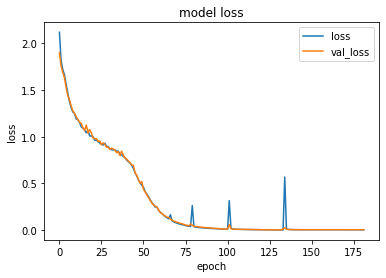

In [77]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [73]:
result = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

expected = [decode(x) for x in y_test]
predicted = [decode(x) for x in result]

for i in range(TEST_SAMPLES):
	print(f'{decode(X_test[i])} =    (Expected={expected[i]},      Predicted={predicted[i]})')

40+67   =    (Expected=107,      Predicted=107)
83+17   =    (Expected=100,      Predicted=100)
34+50   =    (Expected=84 ,      Predicted=84 )
89+2    =    (Expected=91 ,      Predicted=91 )
89+37   =    (Expected=126,      Predicted=126)
16+48   =    (Expected=64 ,      Predicted=64 )
7+12    =    (Expected=19 ,      Predicted=19 )
74+68   =    (Expected=142,      Predicted=142)
55+75   =    (Expected=130,      Predicted=130)
42+61   =    (Expected=103,      Predicted=103)
90+88   =    (Expected=178,      Predicted=178)
69+10   =    (Expected=79 ,      Predicted=79 )
54+60   =    (Expected=114,      Predicted=114)
46+56   =    (Expected=102,      Predicted=102)
95+87   =    (Expected=182,      Predicted=182)
74+33   =    (Expected=107,      Predicted=107)
64+20   =    (Expected=84 ,      Predicted=84 )
9+9     =    (Expected=18 ,      Predicted=18 )
39+8    =    (Expected=47 ,      Predicted=47 )
3+62    =    (Expected=65 ,      Predicted=65 )
24+92   =    (Expected=116,      Predict